In [127]:
import json
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
%matplotlib inline
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter

In [2]:
user_index = json.load(open("../data/user_index.json",'r'))
commitment_index = json.load(open("../data/commitment_index.json",'r'))

In [3]:
max_user_id = max([int(i) for i in user_index.keys()])

In [4]:
for k,v in tqdm(user_index.items()):
    user_index[k]['date'] = datetime.strptime(v['date'], '%d %b %Y')

  0%|          | 0/521632 [00:00<?, ?it/s]

In [5]:
id_for_1_jan_2023 = 722621
for k,v in tqdm(user_index.items()):
    if int(k)<id_for_1_jan_2023 and v['date'].year == 2023:
        user_index[k]['date'] = None

  0%|          | 0/521632 [00:00<?, ?it/s]

In [6]:
last_date = user_index['1']['date']
for i in range(1, max_user_id+1):
    if str(i) in user_index.keys():
        if user_index[str(i)]['date'] == None:
            user_index[str(i)]['date'] = last_date
        else:
            last_date = user_index[str(i)]['date']

In [7]:
for k,v in tqdm(commitment_index.items()):
    commitment_index[k]['start_date'] = datetime.strptime(v['start_date'], '%B %d, %Y')
    commitment_index[k]['end_date'] = datetime.strptime(v['end_date'], '%B %d, %Y')

  0%|          | 0/319928 [00:00<?, ?it/s]

In [8]:
for k,v in tqdm(commitment_index.items()):
    if v['start_date'].year < 2007:
        deta = v['end_date'] - v['start_date']
        commitment_index[k]['start_date'] = user_index[str(v['user_id'])]['date']
        commitment_index[k]['end_date'] = commitment_index[k]['start_date'] + deta

  0%|          | 0/319928 [00:00<?, ?it/s]

{'user_id': 1,
 'start_date': datetime.datetime(2015, 4, 1, 0, 0),
 'end_date': datetime.datetime(2015, 7, 22, 0, 0),
 'title': 'Something',
 'description': 'Finishing Project Condore (X11/Griffon)',
 'type_of_stake': 'No stakes',
 'stake_per_period': 0.0,
 'total_stake': 0.0,
 'length_in_days': 112,
 'self_refree': True,
 'no_of_supporters': 0,
 'no_of_photos': 0,
 'no_of_posts': 0,
 'no_of_reports': 16,
 'sucessful': 0,
 'not_sucessful': 0,
 'not_reported': 16,
 'days_per_reporting': 7.0}

In [97]:
lifeline_raw_data = []
for k,v in tqdm(commitment_index.items()):
    ratio = v['sucessful']*100/v['no_of_reports']
    sample = [ratio]
    if ratio == 100.0:
        sample.append(0)
    else:
        sample.append(1)
    
    if "_reverted" in v['type_of_stake']:
        sample.append('No stakes')
    else:
        sample.append(v['type_of_stake'])
    sample.append(v['self_refree'])
        
    lifeline_raw_data.append(sample)

  0%|          | 0/319928 [00:00<?, ?it/s]

In [98]:
lifeline_df = pd.DataFrame(lifeline_raw_data,columns=['success_percentage','observed','type of stake','self refree'])

In [99]:
lifeline_df

,success_percentage,observed,type of stake,self refree
0,0.0,1,No stakes,True
1,0.0,1,No stakes,True
2,0.0,1,No stakes,True
3,0.0,1,No stakes,True
4,0.0,1,No stakes,True
...,...,...,...,...
319923,0.0,1,No stakes,True
319924,0.0,1,No stakes,False
319925,0.0,1,No stakes,True
319926,0.0,1,No stakes,True


In [100]:
lifeline_df = lifeline_df[lifeline_df['success_percentage']>0.0]

In [101]:
lifeline_df['observed'].value_counts()

observed
1    92298
0    65116
Name: count, dtype: int64

In [102]:
lifeline_df['type of stake'].value_counts()

type of stake
No stakes            66978
Anti-charity         49082
Charity              20891
Money to a friend    16678
stickK                3785
Name: count, dtype: int64

In [103]:
lifeline_df['self refree'].value_counts()

self refree
True     108927
False     48487
Name: count, dtype: int64

# Survival Analysis

Full curve

In [104]:
kmf = KaplanMeierFitter()

In [105]:
T = lifeline_df['success_percentage']
E = lifeline_df['observed']

In [106]:
kmf.fit(T, event_observed=E)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 157414 total observations, 65116 right-censored observations>

<Axes: xlabel='timeline'>

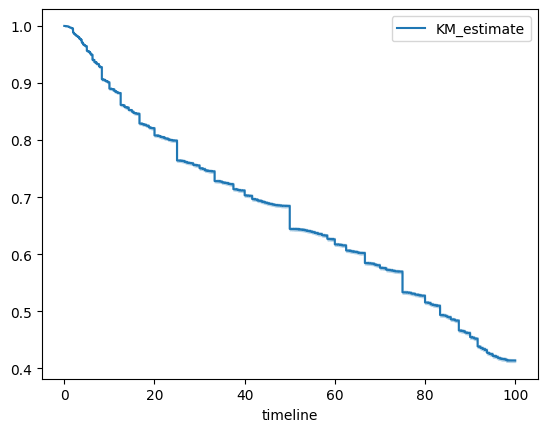

In [107]:
kmf.plot_survival_function()

Self refree

<Axes: xlabel='timeline'>

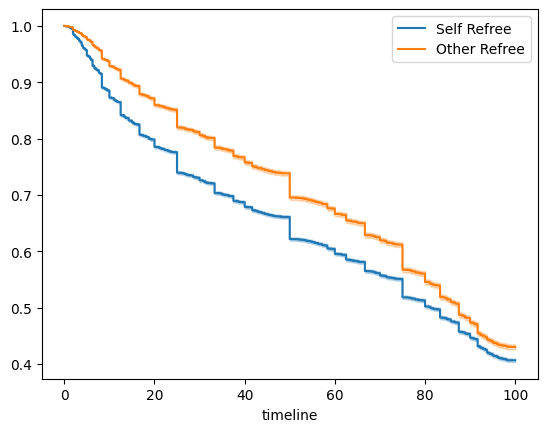

In [108]:
kmf = KaplanMeierFitter()
ax = plt.subplot(111)

self_ref_df = (lifeline_df['self refree']==True)

kmf.fit(T[self_ref_df], event_observed=E[self_ref_df], label="Self Refree")
kmf.plot_survival_function(ax=ax)

kmf.fit(T[~self_ref_df], event_observed=E[~self_ref_df], label="Other Refree")
kmf.plot_survival_function(ax=ax)

In [109]:
results = logrank_test(T[self_ref_df], T[~self_ref_df], E[self_ref_df], E[~self_ref_df], alpha=.99)

results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         292.05 <0.005    215.10

Type of Stake

In [ ]:
No stakes            66978
Anti-charity         49082
Charity              20891
Money to a friend    16678
stickK                3785

<Axes: xlabel='timeline'>

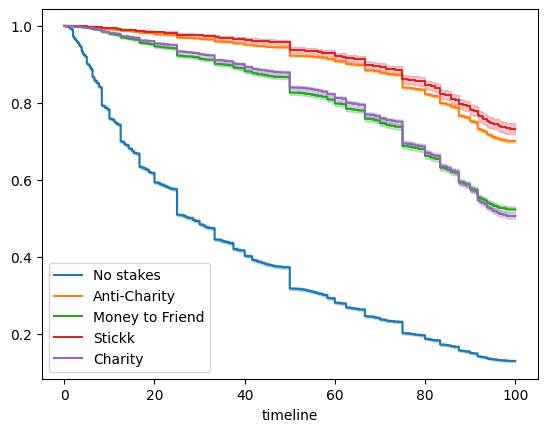

In [111]:
kmf = KaplanMeierFitter()
ax = plt.subplot(111)

no_s = (lifeline_df['type of stake']=='No stakes')
AC = (lifeline_df['type of stake']=='Anti-charity')
C = (lifeline_df['type of stake']=='Charity')
MtoF = (lifeline_df['type of stake']=='Money to a friend')
S = (lifeline_df['type of stake']=='stickK')

kmf.fit(T[no_s], event_observed=E[no_s], label="No stakes")
kmf.plot_survival_function(ax=ax)

kmf.fit(T[AC], event_observed=E[AC], label="Anti-Charity")
kmf.plot_survival_function(ax=ax)

kmf.fit(T[MtoF], event_observed=E[MtoF], label="Money to Friend")
kmf.plot_survival_function(ax=ax)

kmf.fit(T[S], event_observed=E[S], label="Stickk")
kmf.plot_survival_function(ax=ax)

kmf.fit(T[C], event_observed=E[C], label="Charity")
kmf.plot_survival_function(ax=ax)

In [112]:
results = logrank_test(T[no_s], T[C], E[no_s], E[C], alpha=.99)

results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
       16082.30 <0.005       inf

In [113]:
results = logrank_test(T[no_s], T[AC], E[no_s], E[AC], alpha=.99)

results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
       52733.07 <0.005       inf

In [114]:
results = logrank_test(T[C], T[AC], E[C], E[AC], alpha=.99)

results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        2758.26 <0.005       inf

In [115]:
results = logrank_test(T[C], T[MtoF], E[C], E[MtoF], alpha=.99)

results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           3.51 0.06      4.03

In [116]:
results = logrank_test(T[S], T[AC], E[S], E[AC], alpha=.99)

results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          18.09 <0.005     15.53

# COX Regression

In [117]:
commitment_index['408322']

{'user_id': 1,
 'start_date': datetime.datetime(2015, 4, 1, 0, 0),
 'end_date': datetime.datetime(2015, 7, 22, 0, 0),
 'title': 'Something',
 'description': 'Finishing Project Condore (X11/Griffon)',
 'type_of_stake': 'No stakes',
 'stake_per_period': 0.0,
 'total_stake': 0.0,
 'length_in_days': 112,
 'self_refree': True,
 'no_of_supporters': 0,
 'no_of_photos': 0,
 'no_of_posts': 0,
 'no_of_reports': 16,
 'sucessful': 0,
 'not_sucessful': 0,
 'not_reported': 16,
 'days_per_reporting': 7.0}

In [201]:
cox_raw_data = []
for k,v in tqdm(commitment_index.items()):
    ratio = v['sucessful']*100/v['no_of_reports']
    sample = [ratio]
    if ratio == 100.0:
        sample.append(0)
    else:
        sample.append(1)
        
    sample.append(v['stake_per_period'])
#     sample.append(v['total_stake'])
    sample.append(v['length_in_days'])
    sample.append(v['no_of_supporters'])
    sample.append(v['days_per_reporting'])
    
        
    cox_raw_data.append(sample)

  0%|          | 0/319928 [00:00<?, ?it/s]

In [202]:
# Cox_df = pd.DataFrame(cox_raw_data,columns=['success_percentage','observed','stake_per_period','total_stake','length_in_days','no_of_supporters','days_per_reporting'])

Cox_df = pd.DataFrame(cox_raw_data,columns=['success_percentage','observed','stake_per_period','length_in_days','no_of_supporters','days_per_reporting'])

In [203]:
Cox_df

,success_percentage,observed,stake_per_period,length_in_days,no_of_supporters,days_per_reporting
0,0.0,1,0.0,112,0,7.0
1,0.0,1,0.0,53,0,53.0
2,0.0,1,0.0,56,0,7.0
3,0.0,1,0.0,112,0,7.0
4,0.0,1,0.0,56,0,7.0
...,...,...,...,...,...,...
319923,0.0,1,0.0,56,0,7.0
319924,0.0,1,0.0,56,1,7.0
319925,0.0,1,0.0,70,0,7.0
319926,0.0,1,0.0,84,0,7.0


In [204]:
Cox_df = Cox_df[Cox_df['success_percentage']>0.0]

In [205]:
Cox_df['observed'].value_counts()

observed
1    92298
0    65116
Name: count, dtype: int64

In [206]:
cph = CoxPHFitter()

In [207]:
cph.fit(Cox_df, duration_col='success_percentage', event_col='observed')

<lifelines.CoxPHFitter: fitted with 157414 total observations, 65116 right-censored observations>

In [208]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 157414 total observations, 65116 right-censored observations>
             duration col = 'success_percentage'
                event col = 'observed'
      baseline estimation = breslow
   number of observations = 157414
number of events observed = 92298
   partial log-likelihood = -1035986.51
         time fit was run = 2023-07-24 13:09:23 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                  
stake_per_period    -0.03       0.98       0.00            -0.03            -0.02                 0.97                 0.98
length_in_days       0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
no_of_supporters     0.01       1.01       0.00             0.00             0.02                 1.00                 1.02
days_per_reporting  -0.04       0.96       0.00            -0.04            -0.04                 0.96                 0.96

                     cmp to       z      p   -log2(p)
covariate                                            
stake_per_period       0.00 -112.92 <0.005        inf
length_in_days         0.00  196.69 <0.005        inf
no_of_supporters       0.00    2.88 <0.005       7.98
days_per_reporting     0.00  -45.63 <0.005        inf
---
Concordance = 0.79
Partial AIC = 2071981.02
log-likelihood ratio test = 67381.69 on 4 df
-log2(p) of ll-ratio test = inf

<Axes: xlabel='log(HR) (95% CI)'>

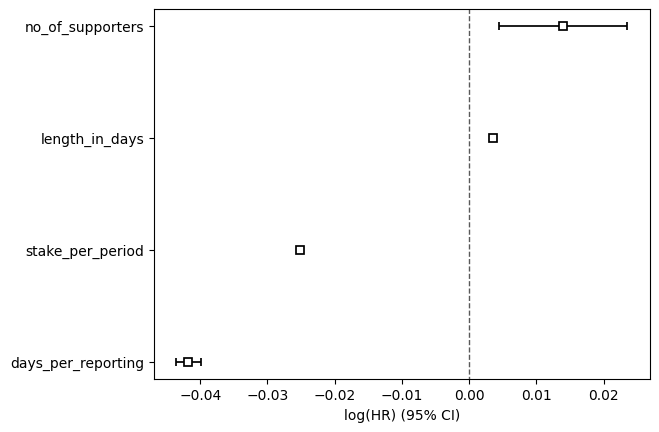

In [209]:
cph.plot()

<Axes: >

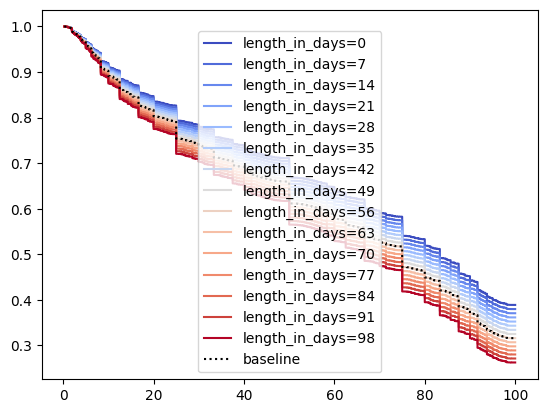

In [193]:
cph.plot_partial_effects_on_outcome(covariates='length_in_days', values=[i for i in range(0,100,7)], cmap='coolwarm')